In [1]:
import glob
import scipy.ndimage
import sklearn.linear_model
import scipy.ndimage.filters

import numpy as np
import pylab as plt

import lemur_util

from lemur_pca import lemur_PCA
from lemur_soar import LemurSOAR


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 10.0)

N_IMAGES = 200
NEUTRAL_FACES_GLOB = 'faces/*a*'  # Select all the neutral faces
SMILING_FACES_GLOB = 'faces/*b*'  # Select all the smiling faces

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

KAGGLE_FACES = 'faces.txt'
N_FEATURES = 3000


# Load neutral faces
neutral = []
for filename in sorted(glob.glob(NEUTRAL_FACES_GLOB)):
  neutral.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
neutral = np.array(neutral)

# Load smiling faces
smiling = []
for filename in sorted(glob.glob(SMILING_FACES_GLOB)):
  smiling.append(scipy.ndimage.imread(filename, flatten=True).flatten() / 255)
smiling = np.array(smiling)

V = lemur_PCA(KAGGLE_FACES, N_FEATURES, 2)

In [2]:
from lemur_soar import LemurSOAR

N_TEST = 5
N_TRAINING = N_IMAGES - N_TEST

# Shuffle images
p = np.random.permutation(smiling.shape[0])

neutral = neutral[p]
smiling = smiling[p]

neutral_pca = neutral.dot(V)
smiling_pca = smiling.dot(V)

neutral_training = neutral[:N_TRAINING]
smiling_training = smiling[:N_TRAINING]

neutral_training_pca = neutral_pca[:N_TRAINING]
smiling_training_pca = smiling_pca[:N_TRAINING]

neutral_test = neutral[N_TRAINING:]
smiling_test = smiling[N_TRAINING:]

neutral_test_pca = neutral_pca[N_TRAINING:]
smiling_test_pca = smiling_pca[N_TRAINING:]

neutral_training = np.append(neutral_training, smiling[:N_TRAINING], axis=0)
smiling_training = np.append(smiling_training, smiling[:N_TRAINING], axis=0)

neutral_training_pca = np.append(neutral_training_pca, smiling_pca[:N_TRAINING], axis=0)
smiling_training_pca = np.append(smiling_training_pca, smiling_pca[:N_TRAINING], axis=0)

feature 0
feature 1000
feature 2000


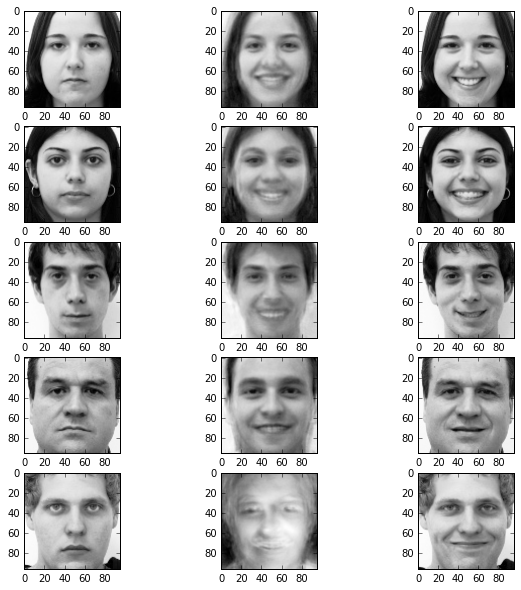

In [7]:
class PCA_RBFtL:
  def set_x(self, X1, X2):
    self.X = np.exp(-.5 * self._dmatrix(X1, X2) / 400)
  def set_y(self, Y1, Y2):
    self.Y = Y1.dot(Y2.T)
    self.Y1 = Y1.T
    self.Y2 = Y2.T
  def __call__(self, k):
    K = np.outer(self.Y1[k], self.Y2[k])
    return self.X * (self.Y - K)
  def _dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return K.T
  
pca_rbftl = LemurSOAR(neutral_training_pca, smiling_training_pca, PCA_RBFtL(), override=True)
pca_rbftl_predictions = pca_rbftl.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_rbftl_predictions, smiling_test)

feature 0
feature 1000
feature 2000


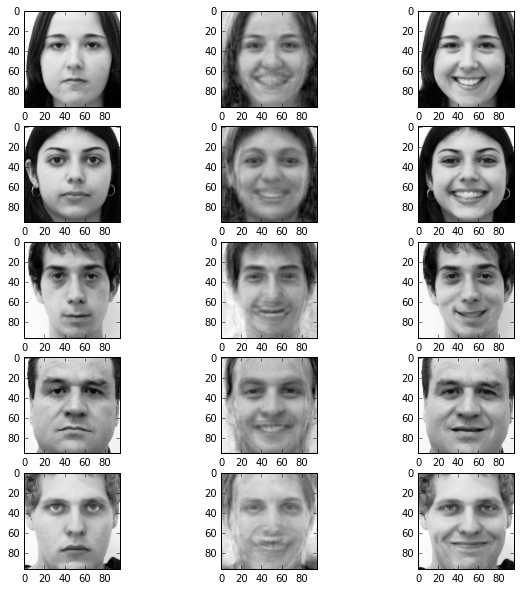

In [42]:
class RR:
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    pass
  def __call__(self, k):
    return self.X + 1

pca_rr = LemurSOAR(neutral_training_pca, smiling_training_pca, RR(), override=True)
pca_rr_predictions = pca_rr.predict(neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_rr_predictions, smiling_test)

feature 0
feature 1000
feature 2000


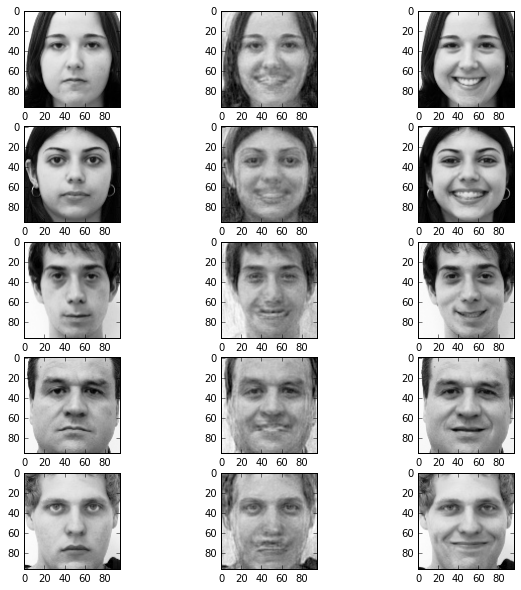

In [61]:
class PCA_LpRBF:
  def __init__(self, s=4e3):
    self.s = s
  def set_x(self, X1, X2):
    self.X = X1.dot(X2.T)
  def set_y(self, Y1, Y2):
    self.Y = np.exp(-.5 * self._dmatrix(Y1, Y2) / self.s)
    self.Y1 = Y1.T.reshape(N_FEATURES, -1, 1)
    self.Y2 = Y2.T.reshape(N_FEATURES, -1, 1)
  def __call__(self, k):
    K = np.exp(-.5 * self._dmatrix(self.Y1[k], self.Y2[k]) / self.s)
    return self.X + (self.Y / K)
  def _dmatrix(self, X, Y):
    K = np.zeros((Y.shape[0], X.shape[0]))
    for i in range(Y.shape[0]):
      K[i] = np.sum((X - Y[i])**2, axis=1)
    return K.T
  
pca_lprbf = LemurSOAR(neutral_training_pca, smiling_training_pca - neutral_training_pca, PCA_LpRBF(), override=True)
pca_lprbf_predictions = (pca_lprbf.predict(neutral_test_pca) + neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, pca_lprbf_predictions, smiling_test)

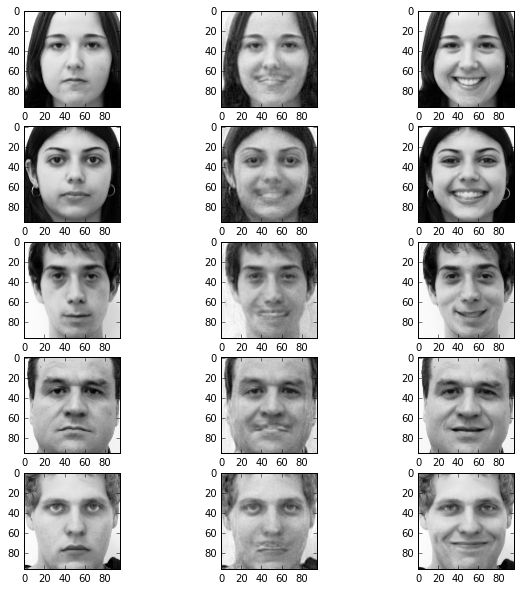

In [67]:
import sklearn.linear_model

twist_ridge = sklearn.linear_model.Ridge(alpha=40).fit(neutral_training_pca, smiling_training_pca - neutral_training_pca)
twist_ridge_predictions = (twist_ridge.predict(neutral_test_pca) + neutral_test_pca).dot(V.T)
lemur_util.plot_predictions(neutral_test, twist_ridge_predictions, smiling_test)